In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor 
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
from sklearn.impute import SimpleImputer
df = pd.read_csv('data/atmFeatures.csv')

In [16]:
X = df.drop(columns=['Cash_Demand_Next_Day', 'ATM_ID', 'Date'])
Y = df['Cash_Demand_Next_Day']

# Define categorical columns for encoding
categorical_cols = ['Day_of_Week', 'Time_of_Day', 'Location_Type', 'Weather_Condition']

# Define numeric columns for scaling
numeric_cols = ['Total_Withdrawals', 'Total_Deposits', 'Holiday_Flag', 'Special_Event_Flag', 
               'Previous_Day_Cash_Level', 'Nearby_Competitor_ATMs', 'Cash_Demand_Lag_2', 
               'Cash_Demand_Lag_7', 'Cash_Demand_MA_3', 'Cash_Demand_MA_7', 'Withdrawals_MA_7', 'Net_Cash_Flow', 'Withdrawal_to_Deposit_Ratio', 'Cash_Level_Change', 'Cash_Utilization_Rate']

# Split dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create preprocessor with imputer for handling NaN values
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Handle NaN values with mean imputation
            ('scaler', StandardScaler())
        ]), numeric_cols)
    ]
)

# Create model pipelines
models = {
    'RandomForest': Pipeline([('preprocessor', preprocessor), 
                             ('regressor', RandomForestRegressor(random_state=42))]),
    
    'XGBoost': Pipeline([('preprocessor', preprocessor), 
                        ('regressor', XGBRegressor(random_state=42, eval_metric='rmse'))]),
    
    'LinearRegression': Pipeline([('preprocessor', preprocessor), 
                                 ('regressor', LinearRegression())])
}

# Train and evaluate all models
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    results[name] = {'MAE': mae, 'R2': r2}
    
    print(f"{name} - MAE: {mae:.3f}, R^2: {r2:.3f}")
    
    # Save each model
    joblib.dump(model, f'data/atm_cash_demand_model_{name.lower()}.joblib')

# Find best model based on R²
best_model = max(results.keys(), key=lambda x: results[x]['R2'])
print(f"\nBest model: {best_model} (R² = {results[best_model]['R2']:.3f})")

Training RandomForest...
RandomForest - MAE: 4853.136, R^2: 0.866
Training XGBoost...
XGBoost - MAE: 4899.299, R^2: 0.861
Training LinearRegression...
LinearRegression - MAE: 4596.261, R^2: 0.884

Best model: LinearRegression (R² = 0.884)


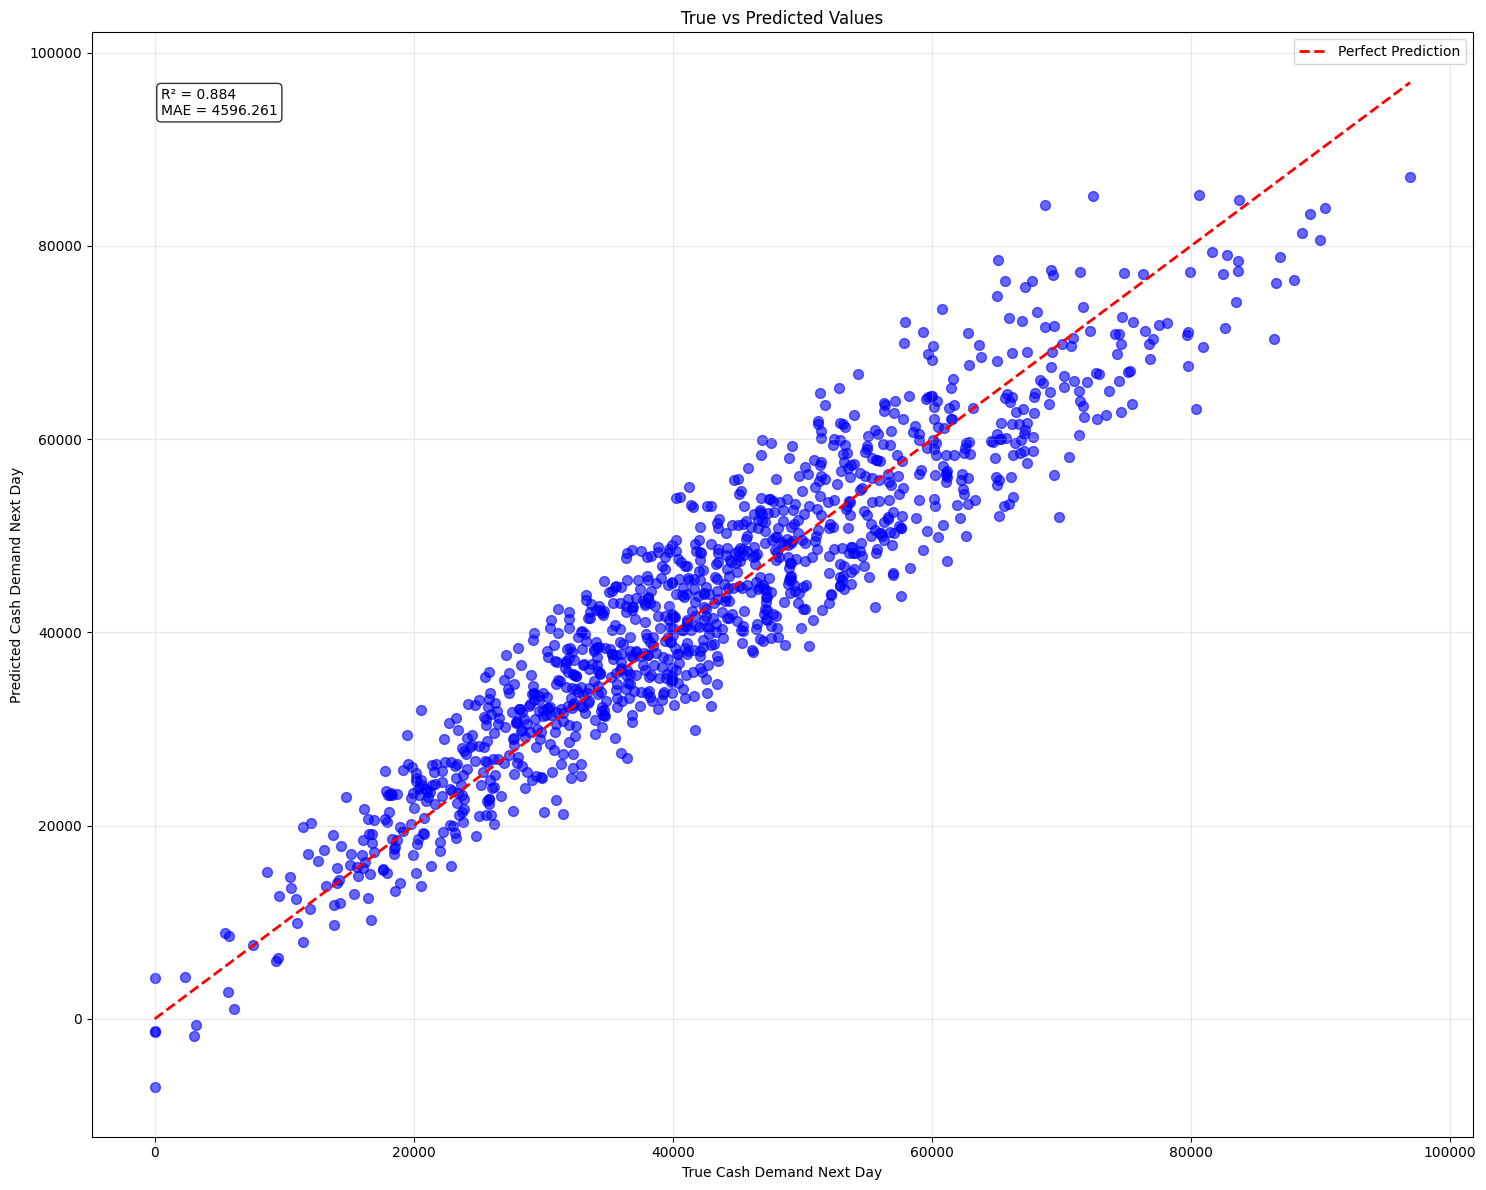

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Get predictions from your trained Linear Regression model
linear_model = models['LinearRegression']  # Your trained model
Y_pred = linear_model.predict(X_test)

# Create figure with single subplot
fig, axes = plt.subplots(1, 1, figsize=(15, 12))

# 1. True vs Predicted Scatter Plot
axes.scatter(Y_test, Y_pred, alpha=0.6, color='blue', s=50)
axes.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2, label='Perfect Prediction')
axes.set_xlabel('True Cash Demand Next Day')
axes.set_ylabel('Predicted Cash Demand Next Day')
axes.set_title('True vs Predicted Values')
axes.grid(True, alpha=0.3)
axes.legend()

# Add R² and MAE to the plot
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
axes.text(0.05, 0.95, f'R² = {r2:.3f}\nMAE = {mae:.3f}', 
          transform=axes.transAxes, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


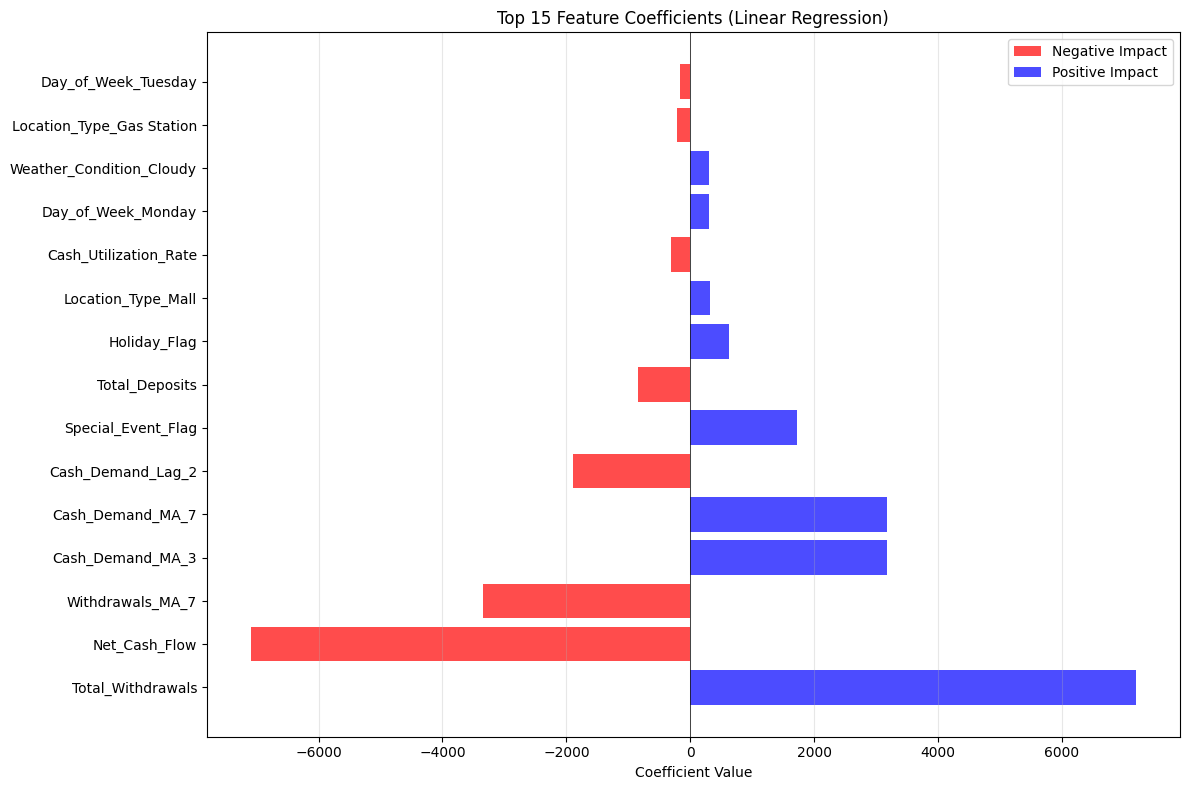

Top 10 Most Important Features:
               Feature  Coefficient
20   Total_Withdrawals  7191.909528
31       Net_Cash_Flow -7091.715552
30    Withdrawals_MA_7 -3344.267562
28    Cash_Demand_MA_3  3175.315029
29    Cash_Demand_MA_7  3171.271496
26   Cash_Demand_Lag_2 -1893.110384
23  Special_Event_Flag  1727.285471
21      Total_Deposits  -847.052188
22        Holiday_Flag   625.582674
13  Location_Type_Mall   317.803358


In [18]:
# Get feature names after preprocessing
feature_names = []

# Get categorical feature names (after one-hot encoding)
cat_encoder = linear_model.named_steps['preprocessor'].named_transformers_['cat']
if hasattr(cat_encoder, 'get_feature_names_out'):
    cat_features = cat_encoder.get_feature_names_out(categorical_cols)
else:
    cat_features = cat_encoder.get_feature_names(categorical_cols)

# Add categorical and numerical feature names
feature_names.extend(cat_features)
feature_names.extend(numeric_cols)

# Get coefficients from linear regression
coefficients = linear_model.named_steps['regressor'].coef_

# Create DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)  # Show top 15 features
colors = ['red' if coef < 0 else 'blue' for coef in top_features['Coefficient']]

plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value')
plt.title('Top 15 Feature Coefficients (Linear Regression)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, axis='x', alpha=0.3)

# Add legend
red_patch = plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Negative Impact')
blue_patch = plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.7, label='Positive Impact')
plt.legend(handles=[red_patch, blue_patch])

plt.tight_layout()
plt.show()

# Print feature importance
print("Top 10 Most Important Features:")
print(feature_importance.head(10)[['Feature', 'Coefficient']])
